In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = '../data'
y_train = pd.read_csv(f'{path}/y_train.csv', index_col = 'key_value')

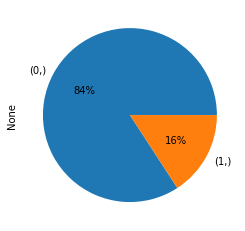

In [3]:
y_train.value_counts().plot(kind='pie', autopct='%1.0f%%');

In [4]:
train = pd.read_pickle('../data/train_score_0.84862.pkl') ### 293 features
test = pd.read_pickle('../data/test_score_0.84862.pkl')
train.shape, test.shape

((358487, 1136), (396666, 1136))

In [5]:
train.dtypes.value_counts()

float64    1048
int32        65
int64        23
dtype: int64

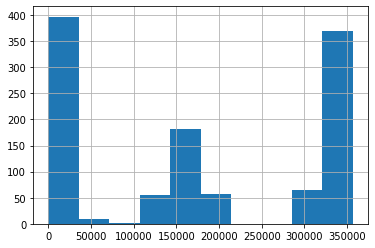

In [6]:
train.isna().sum().hist();

## Entrenando LGBM con hiperparámetros

In [ ]:
train = pd.read_pickle('../data/train_score_0.84862.pkl') ### 293 features
test = pd.read_pickle('../data/test_score_0.84862.pkl')
train.shape, test.shape

In [7]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index].target

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index].target

    learner = LGBMClassifier(n_estimators=1000, boosting_type='gbdt',min_child_samples=1500, colsample_bytree=0.8,
                   subsample=0.8, max_bin=200, learning_rate=0.1)
    
    learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="auc",
                eval_set=[(Xt, yt), (Xv, yv)], verbose=100)
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))  

********** 0 **********
Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.856936	training's binary_logloss: 0.292239	valid_1's auc: 0.84233	valid_1's binary_logloss: 0.303186
[200]	training's auc: 0.872172	training's binary_logloss: 0.280473	valid_1's auc: 0.846739	valid_1's binary_logloss: 0.299657
[300]	training's auc: 0.882948	training's binary_logloss: 0.271993	valid_1's auc: 0.847878	valid_1's binary_logloss: 0.298809
Early stopping, best iteration is:
[327]	training's auc: 0.885625	training's binary_logloss: 0.269881	valid_1's auc: 0.848044	valid_1's binary_logloss: 0.29871
********** 1 **********
Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.856927	training's binary_logloss: 0.292188	valid_1's auc: 0.841971	valid_1's binary_logloss: 0.303186
[200]	training's auc: 0.871942	training's binary_logloss: 0.280424	valid_1's auc: 0.84622	valid_1's binary_logloss: 0.2999
[300]	training's auc: 0.882858	training's bi

In [8]:
fi.sort_values(ascending=False).head(50)

RIESGO_DIRECTO_1_saldoUnique_ult1meses               0.012606
cod_instit_financiera_max_ult1mes                    0.011581
edad                                                 0.010365
RIESGO_DIRECTO_1_saldoStd_ult1meses                  0.008857
COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult12meses    0.008844
ubigeo_mode                                          0.008489
RIESGO_DIRECTO_-1_saldoUnique_ult12meses             0.008307
RIESGO_DIRECTO_-1_saldoMedian_ult1meses              0.008029
cod_instit_financiera_mode_ult1mes                   0.006738
RIESGO_DIRECTO_1_saldoMin_ult1meses                  0.006509
cod_instit_financiera_min_ult1mes                    0.006308
RIESGO_DIRECTO_-1_saldoMedian_ult2meses              0.006118
tipo_credito_11_saldoStd_ult1meses                   0.005895
RIESGO_DIRECTO_1_saldoMedian_ult1meses               0.005428
sexo_0                                               0.005401
condicion_0_saldoUnique_ult12meses                   0.005325
ciiu_mod

In [9]:
fi.to_pickle('fi_lightgbm.pkl')

In [10]:
train_probs_lightgbm = train_probs
test_probs_lightgbm = test_probs
train_probs_lightgbm.to_pickle('train_probs_lightgbm.pkl')
test_probs_lightgbm.to_pickle('test_probs_lightgbm.pkl')

## Entrenando CatBoost con hiperparámetros

In [ ]:
train = pd.read_pickle('../data/train_score_0.84862.pkl') ### 293 features
test = pd.read_pickle('../data/test_score_0.84862.pkl')
train.shape, test.shape

In [11]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index]

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index]

    learner = CatBoostClassifier(boosting_type = 'Plain', n_estimators=1000, eval_metric = 'AUC',
                   colsample_bylevel=1, subsample=1, learning_rate=0.3)
    
    learner.fit(Xt, yt,  early_stopping_rounds=10, 
                eval_set=[(Xt, yt), (Xv, yv)], verbose=100)
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))  

********** 0 **********
0:	test: 0.7093593	test1: 0.7108453	best: 0.7108453 (0)	total: 689ms	remaining: 11m 28s
100:	test: 0.8504688	test1: 0.8395184	best: 0.8396107 (98)	total: 1m 10s	remaining: 10m 24s
200:	test: 0.8647001	test1: 0.8428050	best: 0.8428050 (200)	total: 2m 19s	remaining: 9m 16s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.8431052276
bestIteration = 212

Shrink model to first 213 iterations.
********** 1 **********
0:	test: 0.7269500	test1: 0.7250728	best: 0.7250728 (0)	total: 736ms	remaining: 12m 15s
100:	test: 0.8508043	test1: 0.8398558	best: 0.8399836 (97)	total: 1m 18s	remaining: 11m 43s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.8420045373
bestIteration = 146

Shrink model to first 147 iterations.
********** 2 **********
0:	test: 0.7064753	test1: 0.7146973	best: 0.7146973 (0)	total: 620ms	remaining: 10m 19s
100:	test: 0.8505039	test1: 0.8429398	best: 0.8429398 (100)	total: 1m 15s	remaining: 11m 16s
Stopped by overfitt

In [12]:
fi.sort_values(ascending=False).head(50)

COD_CLASIFICACION_DEUDOR_5_saldoMin_ult1meses        0.186305
COD_CLASIFICACION_DEUDOR_5_saldoUnique_ult5meses     0.024312
RIESGO_DIRECTO_-1_saldoMedian_ult1meses              0.020085
RIESGO_DIRECTO_1_saldoUnique_ult1meses               0.017645
RIESGO_DIRECTO_1_saldoSum_ult1meses                  0.017080
RIESGO_DIRECTO_2_saldoSum_ult1meses                  0.014715
COD_CLASIFICACION_DEUDOR_5_saldoUnique_ult1meses     0.013940
RIESGO_DIRECTO_-1_saldoMean_ult2meses                0.013577
COD_CLASIFICACION_DEUDOR_5_saldoUnique_ult2meses     0.013110
edad                                                 0.012706
COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult12meses    0.012445
COD_CLASIFICACION_DEUDOR_3_saldoMedian_ult4meses     0.011704
cod_instit_financiera_mode_ult1mes                   0.009994
RIESGO_DIRECTO_-1_saldoMedian_ult2meses              0.009545
condicion_0_saldoUnique_ult12meses                   0.009164
cod_instit_financiera_max_ult1mes                    0.008974
sexo_0  

In [13]:
fi.to_pickle('fi_catboost.pkl')

In [14]:
train_probs_catboost = train_probs
test_probs_catboost = test_probs
train_probs_catboost.to_pickle('train_probs_catboost.pkl')
test_probs_catboost.to_pickle('test_probs_catboost.pkl')

## LGBM con Categorical_Feature con hiperparámetros

In [ ]:
train = pd.read_pickle('../data/train_score_0.84862.pkl') ### 293 features
test = pd.read_pickle('../data/test_score_0.84862.pkl')
train.shape, test.shape

In [15]:
var_mode = [ i for i in train.columns if 'mode' in i ]
for i in var_mode:
    train[i] = train[i].astype('category')
    test[i] = test[i].astype('category')

In [16]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index].target

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index].target

    learner = LGBMClassifier(n_estimators=1000, boosting_type='gbdt',min_child_samples=1500, 
                             colsample_bytree=0.8,subsample=0.8, max_bin=200, learning_rate=0.1)
    learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="auc",
                eval_set=[(Xt, yt), (Xv, yv)], verbose=50) 
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))  

********** 0 **********


C:\Users\usuario\anaconda3\envs\venv_datathon\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\usuario\anaconda3\envs\venv_datathon\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.853018	training's binary_logloss: 0.297856	valid_1's auc: 0.83479	valid_1's binary_logloss: 0.309108
[100]	training's auc: 0.86851	training's binary_logloss: 0.284755	valid_1's auc: 0.841822	valid_1's binary_logloss: 0.303217
[150]	training's auc: 0.878911	training's binary_logloss: 0.276473	valid_1's auc: 0.844192	valid_1's binary_logloss: 0.301272
[200]	training's auc: 0.887114	training's binary_logloss: 0.269921	valid_1's auc: 0.84546	valid_1's binary_logloss: 0.300323
Early stopping, best iteration is:
[200]	training's auc: 0.887114	training's binary_logloss: 0.269921	valid_1's auc: 0.84546	valid_1's binary_logloss: 0.300323
********** 1 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.853105	training's binary_logloss: 0.297583	valid_1's auc: 0.83342	valid_1's binary_logloss: 0.309619
[100]	training's auc: 0.868977	training's binary_logloss: 0.284423	val

In [17]:
fi.sort_values(ascending=False).head(50)

ciiu_mode                                            0.113727
cod_instit_financiera_mode_ult1mes                   0.048391
ubigeo_mode                                          0.047601
cod_instit_financiera_mode_ult12mes                  0.028814
cod_instit_financiera_mode_ult2mes                   0.026436
cod_instit_financiera_mode_ult3mes                   0.019045
cod_instit_financiera_mode_ult11mes                  0.018853
cod_instit_financiera_mode_ult4mes                   0.016344
RIESGO_DIRECTO_1_saldoUnique_ult1meses               0.014236
cod_instit_financiera_mode_ult10mes                  0.013086
cod_instit_financiera_mode_ult5mes                   0.013068
cod_instit_financiera_mode_ult8mes                   0.012467
cod_instit_financiera_mode_ult6mes                   0.011805
cod_instit_financiera_mode_ult9mes                   0.011791
cod_instit_financiera_mode_ult7mes                   0.011316
COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult12meses    0.009576
edad    

In [18]:
fi.to_pickle('fi_lightgbm_cf.pkl')

In [19]:
train_probs_lightgbm_cf = train_probs
test_probs_lightgbm_cf= test_probs
train_probs_lightgbm_cf.to_pickle('train_probs_lightgbm_cf.pkl')
test_probs_lightgbm_cf.to_pickle('test_probs_lightgbm_cf.pkl')